In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [25]:
marketplace_df = pd.read_csv('marketplace.csv')
marketplace_df.sample(5)

,Unnamed: 0,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
6001,6001,2024-11-20 14:37:25,2024-11-20 15:13:16,4007286,Ж,mobile,красота и здоровье,True,16,6,7485
8995,8995,2024-12-08 20:57:04,2024-12-08 21:28:15,2919915,Ж,mobile,красота и здоровье,False,0,6,1560
7511,7511,2024-12-01 08:09:11,2024-12-01 08:19:14,7405046,Ж,desktop,канцелярия,False,0,4,2069
2529,2529,2024-10-25 17:42:19,2024-10-25 18:04:07,6553025,М,mobile,детские товары,True,10,5,10532
12735,12735,2024-12-27 14:18:15,2024-12-27 14:35:12,7953743,Ж,desktop,красота и здоровье,False,0,4,1725


In [26]:
marketplace_df = marketplace_df.drop('Unnamed: 0',axis = 1)

In [27]:
marketplace_df.shape

(13620, 10)

In [28]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_session       13620 non-null  object
 1   end_session         13620 non-null  object
 2   user_id             13620 non-null  int64 
 3   sex                 13620 non-null  object
 4   platform            13620 non-null  object
 5   category            13620 non-null  object
 6   consultation        13620 non-null  bool  
 7   cons_duration       13620 non-null  int64 
 8   number_of_products  13620 non-null  int64 
 9   basket_amount       13620 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 971.1+ KB


#### В датафрейме нет пустых значений

In [29]:
marketplace_df.describe()

,user_id,cons_duration,number_of_products,basket_amount
count,1.362000e+04,13620.000000,13620.000000,13620.000000
mean,5.014737e+06,3.769971,3.480617,8070.579148
std,2.321852e+06,5.206834,1.717339,10664.396801
min,1.000078e+06,0.000000,1.000000,72.000000
25%,3.030951e+06,0.000000,2.000000,1203.750000
50%,4.995020e+06,0.000000,3.000000,3834.500000
75%,7.056691e+06,8.000000,5.000000,10171.500000
max,8.999642e+06,19.000000,6.000000,53385.000000


In [30]:
# переводим небходимые столбцы в дату
marketplace_df['start_session'] = pd.to_datetime(marketplace_df['start_session'])
marketplace_df['end_session'] = pd.to_datetime(marketplace_df['end_session'])

In [31]:
# поиск возможных пустых значенйи в столбце
def check_masked_missing(df, column):
        
        # 1. Стандартные NaN/None
        nan_count = df[column].isna().sum()
        print(f"NaN/None: {nan_count}")
        
        # 2. Пустые строки ''
        empty_str = (df[column] == '').sum()
        print(f"Пустые строки (''): {empty_str}")
        
        # 3. Пробелы ' ', '\\t', '\\n'
        whitespace = df[column].astype(str).str.strip().eq('').sum()
        print(f"Только пробелы: {whitespace}")
        
        # 4. Специальные символы: ?, -, N/A, NULL, пусто
        suspicious = df[column].astype(str).str.lower()
        masks = ['?', '-', 'n/a', 'na', 'null', 'none', 'nan', '','!']
        for mask in masks:
            count = (suspicious == mask).sum()
            if count > 0:
                print(f"'{mask}': {count}")
        
        # 5. Строки из пробелов разной длины
        space_only = suspicious.str.match(r'^\s*$').sum()
        print(f"Только пробелы (regex): {space_only}")
        

In [32]:
check_masked_missing(marketplace_df, 'end_session')

NaN/None: 0
Пустые строки (''): 0
Только пробелы: 0
Только пробелы (regex): 0


## Верно ли, что женщины тратят больше денег на покупки на ВезуМаркет?

In [39]:
marketplace_df['month'] = marketplace_df['end_session'].dt.strftime('%Y-%m')

In [40]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [53]:
# Разбивка расходов по месяцам
cost_df = marketplace_df.groupby(['month','sex'],as_index=False) \
    .agg({'basket_amount':'sum'}).rename(columns={'basket_amount':'total_spending'})
cost_df

,month,sex,total_spending
0,2024-10,Ж,12280043
1,2024-10,М,12809949
2,2024-11,Ж,17720267
3,2024-11,М,16891579
4,2024-12,Ж,25781533
5,2024-12,М,24437917


In [75]:
women_sum = cost_df[cost_df['sex'] == 'Ж']['total_spending'].sum()
print(f'Женщины потратили на ВезуМаркет: {women_sum} руб.')

Женщины потратили на ВезуМаркет: 55781843 руб.


In [76]:
men_sum = cost_df[cost_df['sex'] == 'М']['total_spending'].sum()
print(f'Мужчины в сумме потратили на ВезуМаркет: {men_sum} руб.')

Мужчины в сумме потратили на ВезуМаркет: 54139445 руб.


#### Вывод - за исследумые период женщины потратили больше на ВезуМаркет 

## Верно ли, что женщины совершают больше покупок на ВезуМаркет?

In [51]:
freq_df = marketplace_df.groupby('sex',as_index=False) \
    .agg({'user_id':'count'}).rename(columns={'user_id':'number_of_clients'})
freq_df

,sex,number_of_clients
0,Ж,6887
1,М,6733


/var/folders/_q/y78js8613z37pq4ldhx06pc00000gn/T/ipykernel_23307/1568526552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sex', y='number_of_clients',data=freq_df, palette=['mediumpurple','royalblue'])


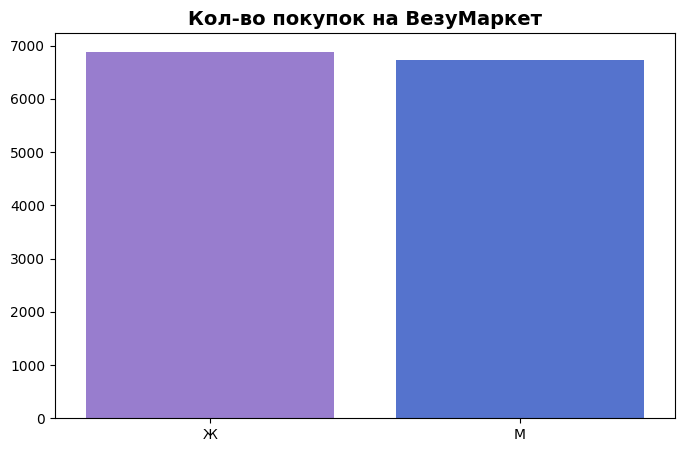

In [62]:
# визуализация
plt.figure(figsize=(8,5))
sns.barplot(x='sex', y='number_of_clients',data=freq_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во покупок на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

#### Вывод - за исследуемый период женщины совершали чаще покупки на ВезуМаркет

## Верно ли, что объем продаж через веб-сайт и мобильное приложение не различается?

In [63]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [65]:
# кол-во уникальных записей в разрезе платформ
marketplace_df.platform.value_counts()

platform
mobile     7991
desktop    5629
Name: count, dtype: int64

In [66]:
# фильтруем датафрей по платформам
mobile_df = marketplace_df.query('platform == "mobile"')
dekstop_df = marketplace_df.query('platform == "desktop"')

In [69]:
# объемы продаж
mobile_volume = np.sum(mobile_df.number_of_products)
dekstop_volume = np.sum(dekstop_df.number_of_products)
print(f'Объем продаж через мобильное приложение: {mobile_volume} товаров')
print(f'Объем продаж через сайт: {dekstop_volume} товаров')

Объем продаж через мобильное приложение: 27799 товаров
Объем продаж через сайт: 19607 товаров


/var/folders/_q/y78js8613z37pq4ldhx06pc00000gn/T/ipykernel_23307/3044490828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='platform', y='number_of_products',data=df_volume, palette=['indigo','midnightblue'])


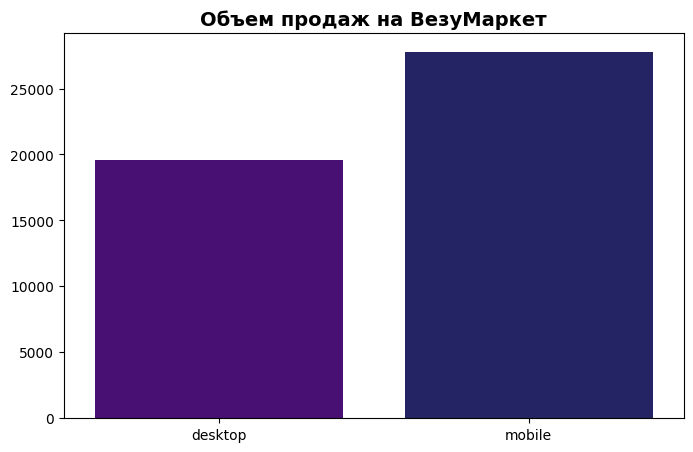

In [74]:
# визуализация
df_volume = marketplace_df.groupby('platform',as_index=False).agg({'number_of_products':'sum'})
plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='number_of_products',data=df_volume, palette=['indigo','midnightblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Объем продаж на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

#### Объем продаж через мобильное приложение превышает продажи через веб-сайт

## Верно ли, что через мобильное приложение и веб-сайт покупки совершает одинаковое количество покупателей?